# Linear classifier: recalls

We will use extensively numpy, pandas, and matplotlib libraries over the lectures.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### A Simple Example: the Iris Dataset

Classifiers are algorithms which we will automatically derive statistical rules from a set of data to provide a decision. In this first session, we will focus on the data structure which is usually used. Indeed, we will start by taking a toy dataset called `iris` available in `scikit-learn`.

The data consists of measurements of three different iris flower species. There are three different species of iris in this particular dataset as illustrated below:

<table style="width:100%">
  <tr>
    <th>Species</th>
    <th>Image</th>
  </tr>
  <tr>
    <td>Iris Setosa</td>
    <td><img src="./figures/iris_setosa.jpg" width="80%"></td>
  </tr>
  <tr>
    <td>Iris Versicolor</td>
    <td><img src="./figures/iris_versicolor.jpg" width="80%"></td>
  </tr>
  <tr>
    <td>Iris Virginica</td>
    <td><img src="./figures/iris_virginica.jpg" width="80%"></td>
  </tr>
</table>

Botanists might be interested in differentiating the iris species automatically. Let's check what data they collected about these flowers.

In [6]:
from sklearn.datasets import load_iris
iris = load_iris()

`iris` is Python dictionary containing all information about the dataset. We can review the different data which we loaded by checking the keys of the dictionary.

In [5]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

`iris.data` will contain the measurements done by the botanist while `iris.target` corresponds to the species.

In [8]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [9]:
iris.target[:5]

array([0, 0, 0, 0, 0])

Checking the size of the data array, we will be able to understand the data representation

In [10]:
iris.data.shape

(150, 4)

`iris.data` is a 2D array containing 150 rows and 4 columns. Each line is a measurement (i.e., sample) while each column is a flower characteristic (i.e., features).

In [11]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

Checking the variable `iris.feature_names`, we can infer the characteristics measured by the botanists. Indeed, they measured the length and width of the petal and sepal of the 150 iris flowers. See below to know the difference between a sepal and petal:

<img src="figures/petal_sepal.jpg" alt="Sepal" style="width: 50%;"/>

(Image: "Petal-sepal". Licensed under CC BY-SA 3.0 via Wikimedia Commons - https://commons.wikimedia.org/wiki/File:Petal-sepal.jpg#/media/File:Petal-sepal.jpg)

We could use pandas dataframe to organise those information in a single data structure.

In [20]:
df_X = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


We can have a quick look of the interaction between the different features.

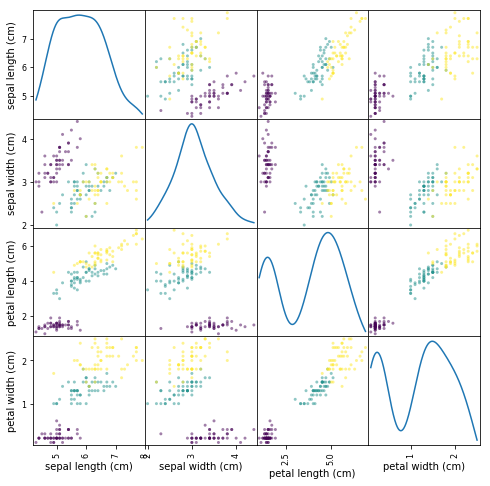

In [25]:
pd.plotting.scatter_matrix(df_X, figsize=(8, 8), diagonal='kde',
                           c=iris.target);

### Intuition of what is a linear classifier

We will first take a subset of data of the iris dataset. It will simplify and allow to come with some intuitions. We will select the sepal length and width.

In [30]:
df_X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [32]:
X = df_X.loc[['sepal length (cm)', 'sepal width (cm)']]

In [34]:
X.head()

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


In addition, we will use only the samples corresponding to the class `0` and `1`.

In [36]:
mask_class_0_1 = np.bitwise_or(iris.target == 0, iris.target == 1)

In [37]:
X = X[mask_class_0_1]
y = iris.target[mask_class_0_1]

We can make a scatter of those data.

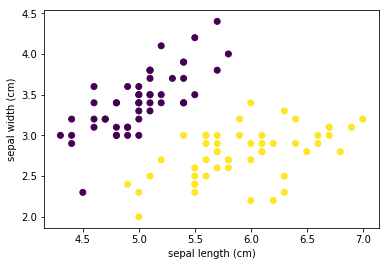

In [44]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1]);

A classifier can be seen as a function $f(\cdot)$ such that given $\mathbf{x}$ (i.e., a row of the matrix `X`) will return $y$ (i.e., the class of the flower). So basically, we have $f(\mathbf{x}) = y$.

When we deal with a linear classifier, it means that the function $f(\mathbf{x})$ is a linear combination of the input features (i.e., sepal width adn sepal length). Therefore, we can formulate this as $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$.

Intuitevely, in our previous example it means that $f(\mathbf{x})$ can be represented by a line (in higher dimension it will be an hyperplane) which will separate the data into two classes. For instance, we can define two points which define such line.

In [51]:
decision_points = np.array(
    [[4.0, 2.0],
     [7.2, 4.5]]
)

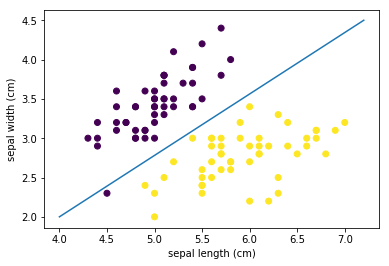

In [52]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.plot(decision_points[:, 0], decision_points[:, 1]);

Recalling the definition of a linear classifier (i.e., $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$), we are able to find the coefficient of this classifier $\mathbf{w}$ by solving the system of linear equations implied by the set of points which we created.

In [55]:
coefs = np.linalg.solve(decision_points,
                        np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

We could also inverse the function to find $\mathbf{w}$ such that $\mathbf{w} = \mathbf{x}^{-1} \cdot \mathbf{b}$

In [57]:
coefs = np.dot(np.linalg.inv(decision_points),
               np.ones(shape=(decision_points.shape[0], 1)))
coefs

array([[ 0.69444444],
       [-0.88888889]])

Therefore, knowing these coefficient we can actually create a linear classifier which can automatically tell us on which side of the line we are.

In [198]:
class ManualLinearClassifier:
    """A linear classifier which we define by passing a pair of points.
    
    Parameters
    ----------
    decision_points : ndarray, shape (2, 2)
        The pair of points defining the decision function.
    
    Attributes
    ----------
    coefs_ : ndarray, shape (n_features, 1)
        The weights defining the decision function.
    intercept_ : ndarray, shape (1,)
        The intercept of the decision function.
    """
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        """Train our classifier.
        
        In this classifier, we will not use the data to find the
        coefficients. Instead, we will use the pair of points
        initially given by the user.
        """
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        """The decision function.
        
        This will tell us the distance and side to the line.
        """
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()


So now we can create a classifier and check that it is working properly.

In [199]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)

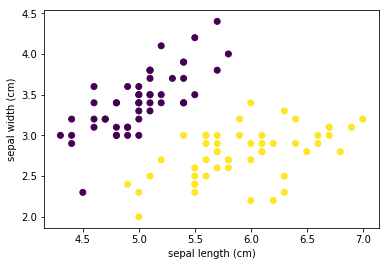

In [200]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1]);

Giving a point (5.0, 2.0) should be part of the yellow point.

In [201]:
clf.decision_function(np.array([[5.0, 2.0]]))

array([0.69444444])

However, a point next to the blue point should have a negative distance.

In [202]:
clf.decision_function(np.array([[5.0, 10.0]]))

array([-6.41666667])

We can plot the line corresponding to $\mathbf{w} \cdot \mathbf{x} + b = 0$

In [203]:
def plot_2d_separator(classifier, X, ax=None, levels=None, eps=None):
    eps = X.std() / 2. if eps is None else eps
    levels = [0] if levels is None else levels
    ax = plt.gca() if ax is None else ax
    
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    decision_values = classifier.decision_function(X_grid)
    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
               colors="black")

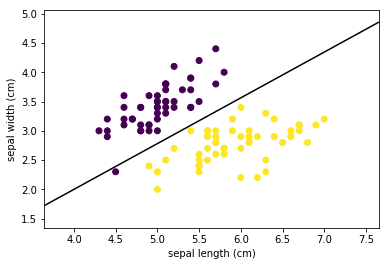

In [204]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1]);
plot_2d_separator(clf, X.values, levels=[0])

We can also plot different distance ranging from -5 to 5.

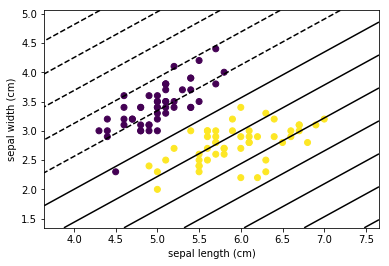

In [205]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y)
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plot_2d_separator(clf, X.values, levels=np.arange(-5, 5, 0.5))

In [206]:
class ManualLinearClassifier:
    """A linear classifier which we define by passing a pair of points.
    
    Parameters
    ----------
    decision_points : ndarray, shape (2, 2)
        The pair of points defining the decision function.
    
    Attributes
    ----------
    coefs_ : ndarray, shape (n_features, 1)
        The weights defining the decision function.
    intercept_ : ndarray, shape (1,)
        The intercept of the decision function.
    """
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        """Train our classifier.
        
        In this classifier, we will not use the data to find the
        coefficients. Instead, we will use the pair of points
        initially given by the user.
        """
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        """The decision function.
        
        This will tell us the distance and side to the line.
        """
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()
    
    def predict(self, X):
        """Return the class associated with the samples.
        
        We can look at the sign of the decision function.
        """
        y_pred = np.sign(self.decision_function(X))
        y_pred[y_pred < 0] = 0
        return y_pred.astype(int)

In [207]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)
clf.predict(X.values)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [208]:
class ManualLinearClassifier:
    """A linear classifier which we define by passing a pair of points.
    
    Parameters
    ----------
    decision_points : ndarray, shape (2, 2)
        The pair of points defining the decision function.
    
    Attributes
    ----------
    coefs_ : ndarray, shape (n_features, 1)
        The weights defining the decision function.
    intercept_ : ndarray, shape (1,)
        The intercept of the decision function.
    """
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        """Train our classifier.
        
        In this classifier, we will not use the data to find the
        coefficients. Instead, we will use the pair of points
        initially given by the user.
        """
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        """The decision function.
        
        This will tell us the distance and side to the line.
        """
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()
    
    def predict(self, X):
        """Return the class associated with the samples.
        
        We can look at the sign of the decision function.
        """
        y_pred = np.sign(self.decision_function(X))
        y_pred[y_pred < 0] = 0
        return y_pred.astype(int)
    
    def score(self, X, y):
        """Compute the mean accuracy using the prediction of our classifier.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [209]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)
print('The mean accuracy is: ', clf.score(X.values, y))

The mean accuracy is:  0.99


In [214]:
class ManualLinearClassifier:
    """A linear classifier which we define by passing a pair of points.
    
    Parameters
    ----------
    decision_points : ndarray, shape (2, 2)
        The pair of points defining the decision function.
    
    Attributes
    ----------
    coefs_ : ndarray, shape (n_features, 1)
        The weights defining the decision function.
    intercept_ : ndarray, shape (1,)
        The intercept of the decision function.
    """
    def __init__(self, decision_points):
        self.decision_points = decision_points
    
    def fit(self, X, y):
        """Train our classifier.
        
        In this classifier, we will not use the data to find the
        coefficients. Instead, we will use the pair of points
        initially given by the user.
        """
        dummy_feature = np.ones(shape=(self.decision_points.shape[0], 1))
        self.intercept_ = -1
        self.coefs_ = np.linalg.solve(self.decision_points, dummy_feature)
        
    def decision_function(self, X):
        """The decision function.
        
        This will tell us the distance and side to the line.
        """
        return (np.dot(X, self.coefs_) + self.intercept_).ravel()
    
    def predict(self, X):
        """Return the class associated with the samples.
        
        We can look at the sign of the decision function.
        """
        y_pred = np.sign(self.decision_function(X))
        y_pred[y_pred < 0] = 0
        return y_pred.astype(int)
    
    def predict_proba(self, X):
        prob = self.decision_function(X)
        prob *= -1
        np.exp(prob, prob)
        prob += 1
        np.reciprocal(prob, prob)
        return np.vstack([1 - prob, prob]).T
    
    def score(self, X, y):
        """Compute the mean accuracy using the prediction of our classifier.
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

In [215]:
clf = ManualLinearClassifier(decision_points)
clf.fit(X, y)
clf.predict_proba(X.values)

array([[0.63863497, 0.36136503],
       [0.56559203, 0.43440797],
       [0.64119523, 0.35880477],
       [0.63670959, 0.36329041],
       [0.67431743, 0.32568257],
       [0.67187257, 0.32812743],
       [0.69588485, 0.30411515],
       [0.63413559, 0.36586441],
       [0.62766725, 0.37233275],
       [0.58729102, 0.41270898],
       [0.63155391, 0.36844609],
       [0.66571971, 0.33428029],
       [0.58257021, 0.41742979],
       [0.66386268, 0.33613732],
       [0.62896466, 0.37103534],
       [0.72167347, 0.27832653],
       [0.67187257, 0.32812743],
       [0.63863497, 0.36136503],
       [0.6033503 , 0.3966497 ],
       [0.69764554, 0.30235446],
       [0.56763838, 0.43236162],
       [0.67857313, 0.32142687],
       [0.73214946, 0.26785054],
       [0.59668385, 0.40331615],
       [0.66571971, 0.33428029],
       [0.54845853, 0.45154147],
       [0.63413559, 0.36586441],
       [0.62245933, 0.37754067],
       [0.60135427, 0.39864573],
       [0.64119523, 0.35880477],
       [0.